In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.image_generation.controllers.predictor_pixelcnn import PixelCNNPredictor, DiagonalLSTMPredictor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.pixelrnn import PixelRNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [3]:
IMAGE_SIZE = 28
BATCH_SIZE = 128

In [4]:
artifact_path = Path("../../artifacts/pixelrnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [5]:
DEVICE = torch.device("cuda:0")

# Data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [7]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

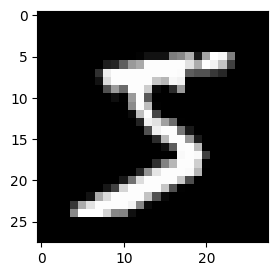

In [8]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

In [9]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [10]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [11]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 28, 28])


# RowLSTM


## model

In [12]:
model = PixelRNN(
    1,
    256,
    hidden_dim=128,
    num_layer=12,
    rnn_type="row",
).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
PixelRNN                                      --
├─Sequential: 1-1                             --
│    └─MaskedConv2d: 2-1                      12,800
├─Sequential: 1-2                             --
│    └─ResBlock: 2-2                          --
│    │    └─ReLU: 3-1                         --
│    │    └─BottleNeck: 3-2                   623,872
│    │    └─Identity: 3-3                     --
│    └─ResBlock: 2-3                          (recursive)
│    │    └─ReLU: 3-4                         --
│    │    └─BottleNeck: 3-5                   (recursive)
│    │    └─Identity: 3-6                     --
│    └─ResBlock: 2-4                          (recursive)
│    │    └─ReLU: 3-7                         --
│    │    └─BottleNeck: 3-8                   (recursive)
│    │    └─Identity: 3-9                     --
│    └─ResBlock: 2-5                          (recursive)
│    │    └─ReLU: 3-10                        --
│    │    

## train

In [15]:
EPOCH = 10

In [16]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [17]:
trainer.recorder.increment_data_size(len(train_data))

In [18]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
scaler = torch.amp.GradScaler()

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 468/468 [09:26<00:00,  1.21s/it]


------------------------------------
Epoch 1
------------------------------------
0.007246037535866103 (0%)


100%|██████████| 468/468 [09:39<00:00,  1.24s/it]


------------------------------------
Epoch 2
------------------------------------
0.006208624927202861 (-14%)


100%|██████████| 468/468 [09:38<00:00,  1.24s/it]


------------------------------------
Epoch 3
------------------------------------
0.006061718802650766 (-2%)


100%|██████████| 468/468 [09:24<00:00,  1.21s/it]


------------------------------------
Epoch 4
------------------------------------
0.005975129899382592 (-1%)


100%|██████████| 468/468 [09:24<00:00,  1.21s/it]


------------------------------------
Epoch 5
------------------------------------
0.005921016650398577 (-1%)


100%|██████████| 468/468 [09:38<00:00,  1.24s/it]


------------------------------------
Epoch 6
------------------------------------
0.005831139703591665 (-2%)


100%|██████████| 468/468 [09:36<00:00,  1.23s/it]


------------------------------------
Epoch 7
------------------------------------
0.005773370469609887 (-1%)


100%|██████████| 468/468 [09:26<00:00,  1.21s/it]


------------------------------------
Epoch 8
------------------------------------
0.0057542058736085875 (0%)


100%|██████████| 468/468 [09:05<00:00,  1.17s/it]


------------------------------------
Epoch 9
------------------------------------
0.005689357057213783 (-1%)


100%|██████████| 468/468 [09:21<00:00,  1.20s/it]

------------------------------------
Epoch 10
------------------------------------
0.005646763796607652 (-1%)


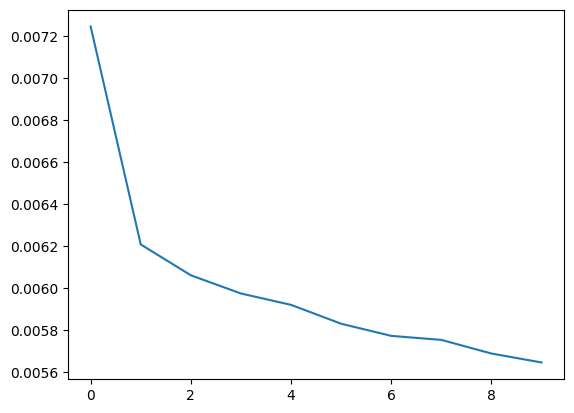

In [19]:
plt.plot(training_loss)

In [14]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelrnn.d{hidden_dim}.l{num_layer}.{rnn_type}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer, rnn_type=model.rnn_type)

In [15]:
model_path

WindowsPath('../../artifacts/pixelrnn/pixelrnn.d128.l12.row.mnist.pth')

In [22]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelrnn\pixelrnn.d128.l12.row.mnist.pth, model size is 2.76MiB


In [16]:
manager.load_weight(model_path, model)

# Diagonal LSTM

## model

In [16]:
model = PixelRNN(
    1,
    256,
    hidden_dim=32,
    num_layer=6,
    rnn_type="diag",
    bidirectional=True,
).to(DEVICE)

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
PixelRNN                                           --
├─Sequential: 1-1                                  --
│    └─MaskedConv2d: 2-1                           3,200
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-2                               --
│    │    └─ReLU: 3-1                              --
│    │    └─BottleNeck: 3-2                        35,392
│    │    └─Identity: 3-3                          --
│    └─ResBlock: 2-3                               (recursive)
│    │    └─ReLU: 3-4                              --
│    │    └─BottleNeck: 3-5                        (recursive)
│    │    └─Identity: 3-6                          --
│    └─ResBlock: 2-4                               (recursive)
│    │    └─ReLU: 3-7                              --
│    │    └─BottleNeck: 3-8                        (recursive)
│    │    └─Identity: 3-9                          --
│    └─ResBlock: 2-5              

## train

In [ ]:
EPOCH = 10

In [16]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [17]:
trainer.recorder.increment_data_size(len(train_data))

In [18]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# scaler = torch.amp.GradScaler()

In [19]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 468/468 [29:16<00:00,  3.75s/it]


------------------------------------
Epoch 1
------------------------------------
0.008440081351995471 (0%)


100%|██████████| 468/468 [28:44<00:00,  3.69s/it]


------------------------------------
Epoch 2
------------------------------------
0.006472236758470537 (-23%)


100%|██████████| 468/468 [29:10<00:00,  3.74s/it]


------------------------------------
Epoch 3
------------------------------------
0.006378049034873651 (-1%)


100%|██████████| 468/468 [27:49<00:00,  3.57s/it]


------------------------------------
Epoch 4
------------------------------------
0.006320170754194267 (-1%)


100%|██████████| 468/468 [26:54<00:00,  3.45s/it]


------------------------------------
Epoch 5
------------------------------------
0.0062697026868661215 (-1%)


100%|██████████| 468/468 [25:57<00:00,  3.33s/it]


------------------------------------
Epoch 6
------------------------------------
0.0062171358158191045 (-1%)


100%|██████████| 468/468 [26:37<00:00,  3.41s/it]


------------------------------------
Epoch 7
------------------------------------
0.0061763065636157985 (-1%)


100%|██████████| 468/468 [26:37<00:00,  3.41s/it]


------------------------------------
Epoch 8
------------------------------------
0.006142008718848227 (-1%)


100%|██████████| 468/468 [26:37<00:00,  3.41s/it]


------------------------------------
Epoch 9
------------------------------------
0.0061154231339693044 (0%)


100%|██████████| 468/468 [27:27<00:00,  3.52s/it]

------------------------------------
Epoch 10
------------------------------------
0.006102407314380007 (0%)


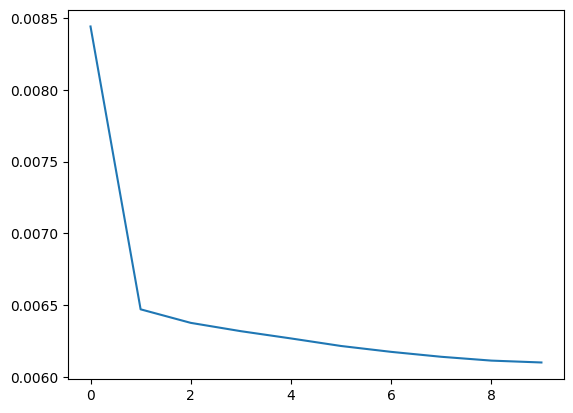

In [23]:
plt.plot(training_loss)

In [35]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelrnn.d{hidden_dim}.l{num_layer}.{rnn_type}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer, rnn_type=model.rnn_type)

In [36]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelrnn\pixelrnn.d32.l6.diag.mnist.pth, model size is 0.21MiB


In [37]:
manager.load_weight(model_path, model)

# Evaluation

## RowLSTM

In [17]:
TEST_BATCH_SIZE = 16

In [18]:
predictor = PixelCNNPredictor(DEVICE)

784it [00:53, 14.57it/s]


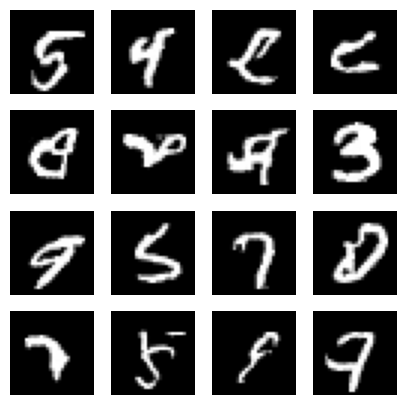

In [21]:
output = predictor.run(model, (TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))
                
plot_grids(
    img_tensor_to_np(output), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

## Diagonal LSTM

In [ ]:
TEST_BATCH_SIZE = 16

In [ ]:
predictor = DiagonalLSTMPredictor(DEVICE)

784it [05:21,  2.44it/s]


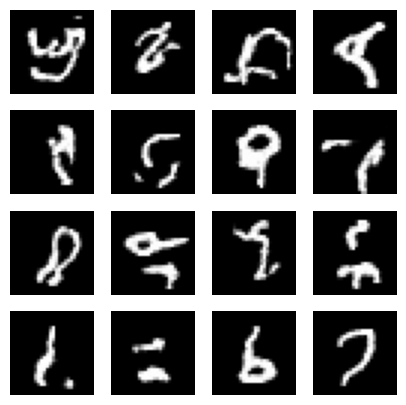

In [ ]:
# diagonal single lstm
output = predictor.run(model, (TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))
                
plot_grids(
    img_tensor_to_np(output), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

784it [02:16,  5.75it/s]


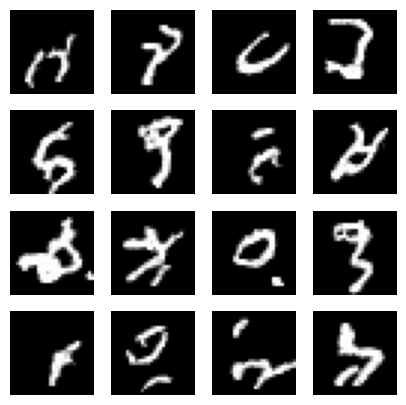

In [ ]:
# diagonal bilstm
output = predictor.run(model, (TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE))
                
plot_grids(
    img_tensor_to_np(output), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)